---
### **Data Bootcamp for Genomic Prediction in Plant Breeding** ###
### **University of Minnesota Plant Breeding Center** ###
#### **June 20 - 22, 2022** ####
---

### **Practical 5:  Modeling Genotype-Environment Interactions (GxE)** ###

<br />
<br />

#### **Source Scripts and Load Data**


In [1]:
WorkDir <- getwd()
setwd(WorkDir)

##Source in functions to be used
source("R_Functions/GS_Pipeline_Jan_2022_FnsApp.R")
source("R_Functions/bootcamp_functions.R")
gc()



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****



Attaching package: ‘bWGR’


The following objects are masked from ‘package:NAM’:

    CNT, emBA, emBB, emBC, emBL, emCV, emDE, emEN, emGWA, emML, emML2,
    emRR, GAU, GRM, IMP, KMUP, KMUP2, markov, mkr, mkr2X, mrr, mrr2X,
    mrrFast, SPC, SPM, wgr



Attaching package: ‘emoa’


The following object is masked from ‘package:dplyr’:

    coalesce



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select



Attaching package: ‘sommer’


The following objects are masked from ‘package:rrBLUP’:

    A.mat, GWAS


Welcome to rTASSEL (version 0.9.26)
 • Consider start

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,5657719,302.2,8579101,458.2,6279418,335.4
Vcells,9737249,74.3,15290241,116.7,12675198,96.8


#### **Read Genotype File using vcfR** ####

In [2]:

##Load in genotype data. Use package vcfR to read in and work with vcf file.
infileVCF <- "Data/SoyNAM_Geno.vcf"
genotypes_VCF <- read.table(infileVCF)
vcf <- read.vcfR(infileVCF, verbose = FALSE)
vcf

***** Object of Class vcfR *****
5189 samples
20 CHROMs
4,292 variants
Object size: 171.1 Mb
25.41 percent missing data
*****        *****         *****


#### **Convert VCF file format to numerical matrix format.**
#### Final genotype matrix is geno_num

In [5]:
gt <- extract.gt(vcf, element = "GT", as.numeric = F)
fix_T <- as_tibble(getFIX(vcf))
gt2 <- matrix(0, ncol = ncol(gt), nrow = nrow(gt))
colnames(gt2) <- colnames(gt)
rownames(gt2) <- rownames(gt)
gt2a <- apply(gt,2, function(x) gsub("1/1","1",x))
gt2b <- gsub("0[/|]0","0",gt2a)
gt2c <- gsub("[10][/|][10]","0.5",gt2b)
gt2d <- gsub("\\.[/|]\\.","NA",gt2c)

gt2d_num<- apply(gt2d,2,as.numeric)
rownames(gt2d_num)<- rownames(gt2d)
geno_num <- t(gt2d_num)
dim(geno_num)
rm(list=grep("gt2",ls(),value=TRUE))


[1] 5189 4292

#### **Filter Genotypic Data**

In [6]:
##Filter markers on % missing
miss <- function(x){length(which(is.na(x)))}
mrkNA <- (apply(geno_num, MARGIN=2, FUN=miss))/dim(geno_num)[1]
ndx <- which(mrkNA > 0.2)

if (length(ndx)>0) geno_num2 <- geno_num[, -ndx] else geno_num2 <- geno_num

##Filter individuals on % missing
indNA <- (apply(geno_num2, MARGIN=1, FUN=miss))/dim(geno_num2)[2]
ndx2 <- which(indNA > 0.5)

 if(length(ndx2)>0) geno_num3 <- geno_num2[-ndx2, ] else geno_num3 <- geno_num2


##Filter markers based on MAF
maf <- apply(geno_num3, MARGIN=2, FUN=mean, na.rm=T)
ndx3 <- which(maf<0.05 | maf>0.95) 

if (length(ndx3)>0) geno_num4 <- geno_num2[, -ndx3] else geno_num4 <- geno_num3
  
dim(geno_num4)

[1] 5189 1428

#### **Import Phenotypic Data and Merge Geno-Pheno Data**

In [7]:

pheno <- read.csv("Data/SoyNAM_Pheno.csv")

geno_num4_x <- cbind(rownames(geno_num4),geno_num4)
colnames(geno_num4_x)[1]<- "strain"

### Check strain names have same format in pheno and geno 
pheno[,1] <- gsub("[-.]","",pheno[,1])
geno_num4_x[,1] <- gsub("[-.]","",geno_num4_x[,1])

## Merge Geno and Pheno Data
Data <- merge(geno_num4_x,pheno,by="strain",all=TRUE)

## Remove with missing yiled_blup values 

YldNA_Indices <- which(is.na(Data$yield))
if(length(YldNA_Indices) >0){Data_Sub <- Data[-YldNA_Indices,]}else{Data_Sub <- Data}


genoStrain <- unique(as.character(geno_num4_x[,"strain"]))

genoStrainIndices <- which(Data_Sub[,"strain"] %in% genoStrain)
length(genoStrainIndices)
genoIndices <- grep("ss",colnames(geno_num4_x))
initGenoIndx <- genoIndices[1]
finalGenoIndx <- genoIndices[length(genoIndices)]
phenoIndices <- c(1,c((finalGenoIndx+1):ncol(Data_Sub)))

pheno_sub <- Data_Sub[genoStrainIndices,phenoIndices]
geno_num4b <- Data_Sub[genoStrainIndices,c(1,genoIndices)]


uniqueStrainIndices<- which(!duplicated(geno_num4b[,"strain"]))

if(length(uniqueStrainIndices)>0) {geno_num5 <- geno_num4b[uniqueStrainIndices,]}else{geno_num5 <- geno_num4b}

dim(geno_num5)

rm(geno_num4b)
rm(geno_num4)
rm(geno_num3)
rm(geno_num2)

### set 'yield' colname to 'Yield_blup'

yldCol <- which(colnames(pheno_sub) %in% "yield")
colnames(pheno_sub)[yldCol] <- "Yield_blup" 



[1] 55981

[1] 5148 1429

#### **Subset Environments** 

In [8]:
### Select 3 environs with largest number of evaluations (lines)  

env_sub <-  names(which(table(pheno_sub[,"environ"])>5100)[1:3])

env_sub_indices <- which(pheno_sub[,"environ"] %in% env_sub)

## Subset Data and Geno tables 
DT <- pheno_sub[env_sub_indices,]

DT$environ <- as.factor(DT$environ)

dim(DT)

[1] 15355    16

#### **Impute Genotype Table** ###

In [9]:
#### Impute genotable using markov function from 'NAM' package 

geno_imp <- markov(apply(geno_num5[,-1],2,as.numeric))
rownames(geno_imp) <- geno_num5[,"strain"]
dim(geno_imp)

[1] 5148 1428

In [10]:
### 
env_geno_sub_indices <- which(rownames(geno_imp) %in% unique(DT[,"strain"]))
geno_imp_sub <- geno_imp[env_geno_sub_indices,]

dim(geno_imp_sub)

[1] 5145 1428

#### **Relationship Matrix Using A.mat** 

In [11]:
K_rr <- A.mat(geno_imp_sub)
colnames(K_rr) <-rownames(geno_imp_sub)
rownames(K_rr) <- rownames(geno_imp_sub)
A <- K_rr
dim(A)



[1] 5145 5145

#### **Subset Genotypes for Computation Demo** 

In [12]:
  
A_Sub <- A[1:500,1:500]
DT_Sub <- DT[which(DT[,"strain"] %in% rownames(A_Sub)),]

E <- diag(length(unique(DT$environ)))
rownames(E) <- colnames(E) <- unique(DT$environ)
dim(E)

### Same set of strains in each of the environments 

rmStrains <- names(which(table(DT_Sub[,"strain"]) <3))
DT_Sub1 <- DT_Sub[-which(DT_Sub[,"strain"] %in% rmStrains),]

A_Sub1 <- A_Sub[-which(rownames(A_Sub) %in% rmStrains),-which(rownames(A_Sub) %in% rmStrains)]
dim(A_Sub1)

[1] 3 3

[1] 494 494

<br />
<br />

### **Exercise 1 - Compare a few Var-Covar structures in SOMMER package**


<br />

#### **1a -Model with Main Effect** #### 
##### Model environment as fixed effect (estimate population mean for each of the environments) and estimate random effects for genotypes 


In [13]:

fitMain <- mmer(Yield_blup~environ-1,
                random=~vs(strain,Gu=A_Sub1),
                rcov=~units,
                data=DT_Sub1,verbose=FALSE)
summary(fitMain)


The vs() function will be removed soon. Please start using the vsr() function.

================================================================
           Multivariate Linear Mixed Model fit by REML           
************************  sommer 4.1  ************************ 
================================================================
         logLik      AIC      BIC Method Converge
Value -546.3708 1098.742 1114.645     NR     TRUE
================================================================
Variance-Covariance components:
                               VarComp VarCompSE Zratio Constraint
u:strain.Yield_blup-Yield_blup    8583      5946  1.444   Positive
units.Yield_blup-Yield_blup     375177     13971 26.853   Positive
================================================================
Fixed effects:
       Trait         Effect Estimate Std.Error t.value
1 Yield_blup environIA_2012     3128     27.74   112.8
2 Yield_blup environIA_2013     2795     27.74   100.8
3 Yield_blup environIL_2012     3611     27.74   130.2
================================================================
Groups and observations:
         Yield_blup
u:strain        494
================================================================
Use the '$' sign to access results and parameters

0.4772414


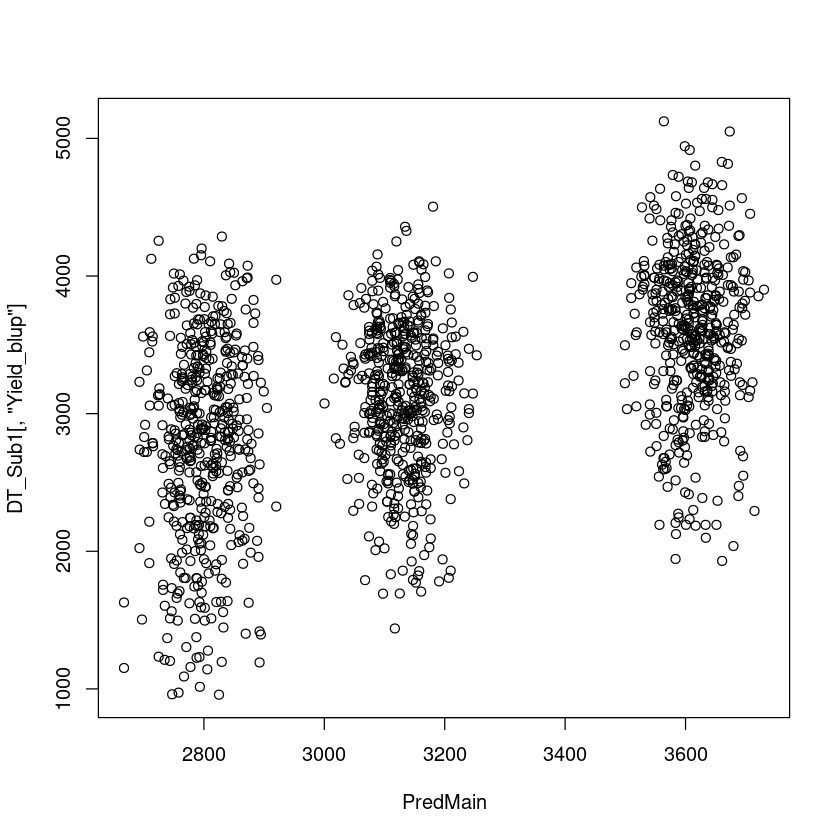

In [14]:

m <- model.matrix(~ environ-1 ,data=DT_Sub1)
m_beta <- m %*% as.numeric(fitMain$Beta[,3]) 
PredMain <- m_beta+fitMain$U$`u:strain`$Yield_blup
cor(PredMain,DT_Sub1[,"Yield_blup"]) 
plot(PredMain,DT_Sub1[,"Yield_blup"])

<br />

#### **1b -Model with Compound Symmetry var-covar structure** ####
##### Compound symmetry assumes GxE effects and also assumes constant correlation among environments

In [15]:

E <- diag(length(unique(DT_Sub1$environ)))
rownames(E) <- colnames(E) <- unique(DT_Sub1$environ)

EA <- kronecker(E,A_Sub1, make.dimnames = TRUE)
DT_Sub1$environ <- as.factor(DT_Sub1$environ)
DT_Sub1$strain <- as.factor(DT_Sub1$strain)

fitCS <- mmer(Yield_blup~environ-1,
              random= ~ vs(strain, Gu=A_Sub1) + vs(environ:strain, Gu=EA),
              rcov= ~ units,
              data=DT_Sub1, verbose = FALSE)
summary(fitCS)

The vs() function will be removed soon. Please start using the vsr() function.The vs() function will be removed soon. Please start using the vsr() function.

========================================================================
               Multivariate Linear Mixed Model fit by REML               
****************************  sommer 4.1  **************************** 
========================================================================
         logLik      AIC      BIC Method Converge
Value -539.1218 1084.244 1100.147     NR     TRUE
========================================================================
Variance-Covariance components:
                                       VarComp VarCompSE Zratio Constraint
u:strain.Yield_blup-Yield_blup               0      7977  0.000   Positive
u:environ:strain.Yield_blup-Yield_blup   33142     13969  2.373   Positive
units.Yield_blup-Yield_blup             360761     13832 26.081   Positive
========================================================================
Fixed effects:
       Trait         Effect Estimate Std.Error t.value
1 Yield_blup environIA_2012     3131     27.67   113.1
2 Yield_blup environIA_2013     2790     27.67   100.8
3 Yield_blup environIL_2012     3612     27.67   130.5
========================================================================
Groups and observations:
                 Yield_blup
u:strain                494
u:environ:strain       1482
========================================================================
Use the '$' sign to access results and parameters

0.4686045


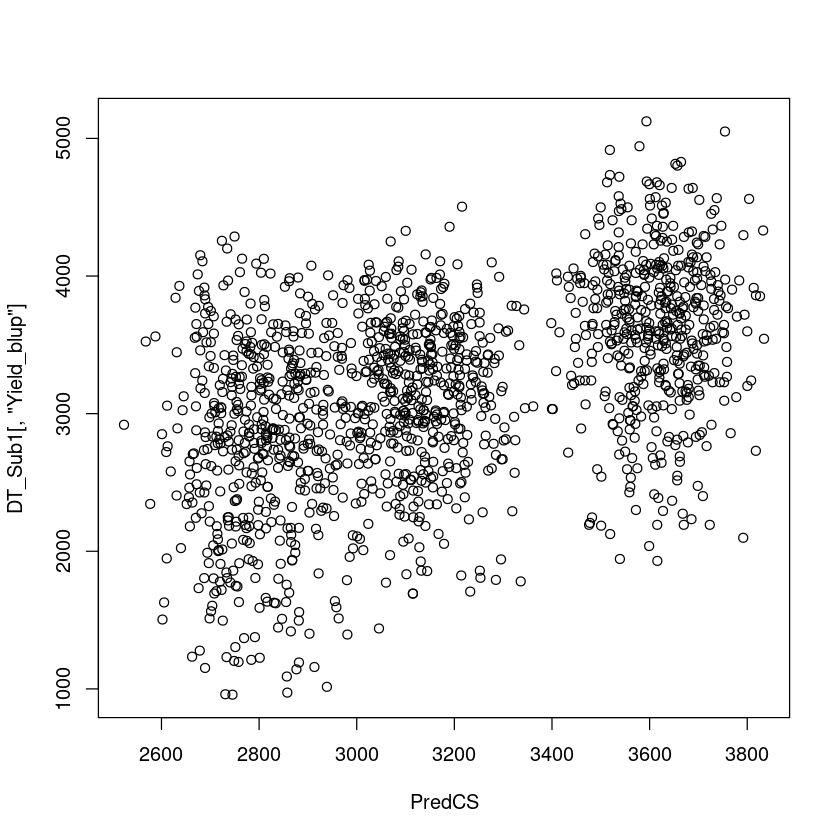

In [16]:

m <- model.matrix(~ environ-1 ,data=DT_Sub1)
m_beta <- m %*% as.numeric(fitCS$Beta[,3]) 
PredCS <- m_beta+fitCS$U$`u:environ:strain`$Yield_blup
cor(PredCS,DT_Sub1[,"Yield_blup"]) 
plot(PredCS,DT_Sub1[,"Yield_blup"])

<br /> 

#### **1c -Model with Compound Symmetry + Diagonal Structure** ####
##### Heterogeneous gxe variance among environments and constant genetic co-variance among environments 

In [18]:
fitCSDG <- mmer(Yield_blup~environ-1,
                random=~vsr(strain,Gu=A_Sub1) +vsr(dsr(environ),strain,Gu=A_Sub1),
                rcov=~units,
                data=DT_Sub1,verbose=FALSE) 

summary(fitCSDG)

======================================================================
              Multivariate Linear Mixed Model fit by REML              
***************************  sommer 4.1  *************************** 
======================================================================
         logLik      AIC      BIC Method Converge
Value -537.5147 1081.029 1096.933     NR     TRUE
======================================================================
Variance-Covariance components:
                                     VarComp VarCompSE  Zratio Constraint
u:strain.Yield_blup-Yield_blup          1109      7976  0.1390   Positive
IA_2012:strain.Yield_blup-Yield_blup   11203     14991  0.7473   Positive
IA_2013:strain.Yield_blup-Yield_blup   38447     22794  1.6867   Positive
IL_2012:strain.Yield_blup-Yield_blup   56960     27643  2.0605   Positive
units.Yield_blup-Yield_blup           359481     13783 26.0807   Positive
======================================================================
Fixed effects:
       Trait         Effect Estimate Std.Error t.value
1 Yield_blup environIA_2012     3130     27.28   114.7
2 Yield_blup environIA_2013     2789     27.71   100.6
3 Yield_blup environIL_2012     3612     27.93   129.4
======================================================================
Groups and observations:
               Yield_blup
u:strain              494
IA_2012:strain        494
IA_2013:strain        494
IL_2012:strain        494
======================================================================
Use the '$' sign to access results and parameters

In [19]:

m2 <- cbind(c(rep(1,nrow(DT_Sub1)/3),rep(0,2*nrow(DT_Sub1)/3)),c(rep(0,nrow(DT_Sub1)/3),rep(1,nrow(DT_Sub1)/3),rep(0,nrow(DT_Sub1)/3)),
c(rep(0,nrow(DT_Sub1)/3),rep(0,nrow(DT_Sub1)/3),rep(1,nrow(DT_Sub1)/3)))

m_beta <- m2 %*% as.numeric(fitCSDG$Beta[,3]) 
length(m_beta)
m_env_strain <- do.call(cbind,lapply(fitCSDG$U,function(x) x$Yield_blup))
dim(m_env_strain)
envStrain_blup <-c(m_env_strain[,2:4])                              
                  
strain_blup <- rep(fitCSDG$U$`u:strain`$Yield_blup,3)
length(strain_blup)

[1] 1482

[1] 494   4

[1] 1482

0.543284


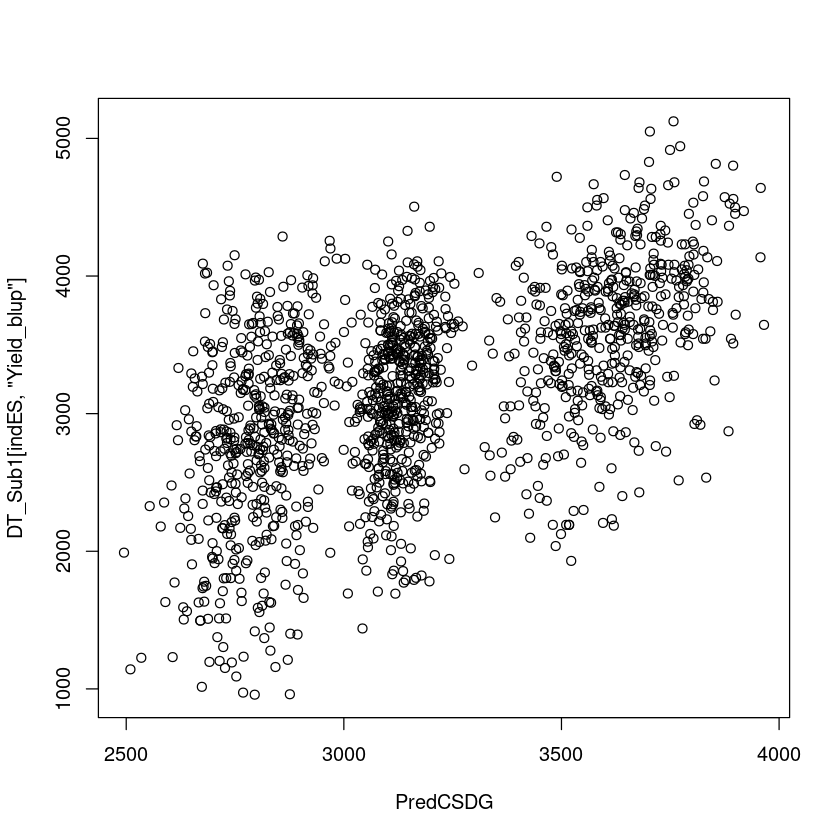

In [20]:
PredCSDG <- m_beta+strain_blup+envStrain_blup

indES <-  sort.int(as.numeric(DT_Sub1[,"environ"]),decreasing=FALSE,index.return=TRUE)[[2]]

cor(PredCSDG,DT_Sub1[indES,"Yield_blup"]) 
plot(PredCSDG,DT_Sub1[indES,"Yield_blup"])


<br />

#### **1d- Model with US - Unstructured Variance-Covariance** ####
Model with heterogeneous variance for each of the environments and heterogeneous covariance for every combination of environments

In [22]:
fitUS <- mmer(Yield_blup~environ-1,
                random=~vsr(usr(environ),strain,Gu=A_Sub1),
                rcov=~units,
                data=DT_Sub1,verbose=FALSE) 
summary(fitUS)

==============================================================================
                  Multivariate Linear Mixed Model fit by REML                  
*******************************  sommer 4.1  ******************************* 
==============================================================================
         logLik      AIC      BIC Method Converge
Value -534.6765 1075.353 1091.256     NR     TRUE
==============================================================================
Variance-Covariance components:
                                              VarComp VarCompSE  Zratio
IA_2012:strain.Yield_blup-Yield_blup          13999.9     13344  1.0492
IA_2013:IA_2012:strain.Yield_blup-Yield_blup   -378.4     11901 -0.0318
IA_2013:strain.Yield_blup-Yield_blup          40023.9     21165  1.8910
IL_2012:IA_2012:strain.Yield_blup-Yield_blup  16497.6     14083  1.1715
IL_2012:IA_2013:strain.Yield_blup-Yield_blup -36052.1     18347 -1.9650
IL_2012:strain.Yield_blup-Yield_blup          63232.4     27476  2.3014
units.Yield_blup-Yield_blup                  358944.8     13740 26.1231
                                             Constraint
IA_2012:strain.Yield_blup-Yield_blup           Positive
IA_2013:IA_2012:strain.Yield_blup-Yield_blup   Unconstr
IA_2013:strain.Yield_blup-Yield_blup           Positive
IL_2012:IA_2012:strain.Yield_blup-Yield_blup   Unconstr
IL_2012:IA_2013:strain.Yield_blup-Yield_blup   Unconstr
IL_2012:strain.Yield_blup-Yield_blup           Positive
units.Yield_blup-Yield_blup                    Positive
==============================================================================
Fixed effects:
       Trait         Effect Estimate Std.Error t.value
1 Yield_blup environIA_2012     3129     27.26   114.8
2 Yield_blup environIA_2013     2791     27.61   101.1
3 Yield_blup environIL_2012     3617     27.87   129.8
==============================================================================
Groups and observations:
                       Yield_blup
IA_2012:strain                494
IA_2013:IA_2012:strain        988
IA_2013:strain                494
IL_2012:IA_2012:strain        988
IL_2012:IA_2013:strain        988
IL_2012:strain                494
==============================================================================
Use the '$' sign to access results and parameters

[1] "IA_2012" "IA_2013" "IL_2012"
[1] "IA_2012:strain"         "IA_2013:IA_2012:strain" "IA_2013:strain"        
[4] "IL_2012:IA_2012:strain" "IL_2012:IA_2013:strain" "IL_2012:strain"        


[1] 0.5532487

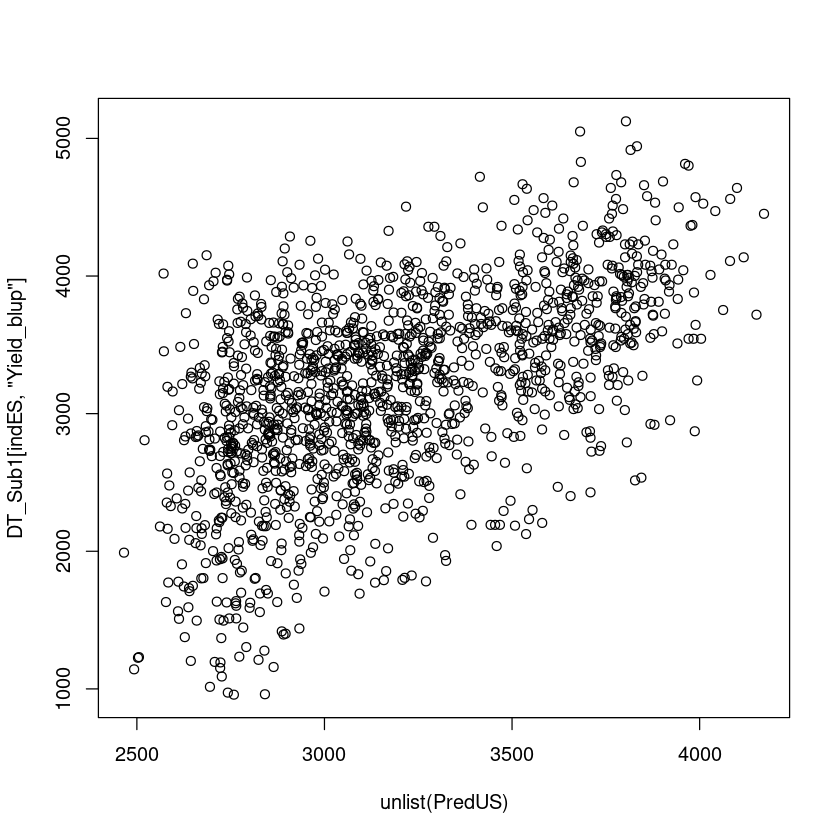

In [23]:
envNames <- levels(factor(DT_Sub1$environ))
print(envNames)
print(names(fitUS$U))
env1Ind <- c(1,3,6)
U_envStrain <- list()
PredUS <- list()
  for(i in 1:length(envNames)){
       envInd <-  grep(envNames[i],names(fitUS$U))
       envIndNames <-  grep(envNames[i],names(fitUS$U),value=TRUE)
       U_envStrain[[i]] <-  as.numeric(fitUS$U[[env1Ind[i]]]$Yield_blup)
       for(j  in 2:length(envInd)){ 
         indJ <- envInd[j]
         b <- cbind(names(fitUS$U[[indJ]]$Yield_blup),fitUS$U[[indJ]]$Yield_blup)
         colnames(b) <- c("strain","Yield_blup")
         b_group <- as_tibble(b) %>% group_by(strain)
         YldBlup_group <- b_group %>% summarise(Yield_blup = sum(as.numeric(Yield_blup)))
         U_envStrain[[i]] <- U_envStrain[[i]] +YldBlup_group[,2]
       }
      
      PredUS[[i]] <- c(U_envStrain[[i]] + fitUS$Beta[i,3])
     }

indES <-  sort.int(as.numeric(DT_Sub1[,"environ"]),decreasing=FALSE,index.return=TRUE)[[2]]  
cor(unlist(PredUS),DT_Sub1[indES,"Yield_blup"]) 
plot(unlist(PredUS),DT_Sub1[indES,"Yield_blup"]) 

<br />
<br />

### **Exercise 2 - Predict performance of tested and untested genotypes in tested and untested environments** ###

#### **2a - Tested Genotypes in Untested Environment**

In [24]:
### Remove lines from IA2013 and train the model using IA2012 and IL2013 only and predict 
### performance of lines for IA2013 (untested environ) and compare accuracy with model 
### incorporating data from IA2013 in the training model 

tstIndices1 <- which(DT_Sub1[,"environ"] %in% "IA_2013") 

DT_Sub1A <- DT_Sub1
DT_Sub1A[tstIndices1 ,"Yield_blup"] <- NA
#DT_Sub1A[tstIndices1 ,"environ"] <- NA

dim(DT_Sub1A)

[1] 1482   16

#### **Unstructured Var-Covar for Untested Environment**

In [27]:
fitUS1A <- mmer(Yield_blup~factor(environ)-1,
                random=~vsr(usr(factor(environ)),strain,Gu=A_Sub1),
                rcov=~units,
                data=DT_Sub1A,verbose=FALSE) 
summary(fitUS1A)



==============================================================================
                  Multivariate Linear Mixed Model fit by REML                  
*******************************  sommer 4.1  ******************************* 
==============================================================================
         logLik      AIC      BIC Method Converge
Value -392.3792 788.7585 798.5498     NR     TRUE
==============================================================================
Variance-Covariance components:
                                             VarComp VarCompSE Zratio
IA_2012:strain.Yield_blup-Yield_blup           21730     14047  1.547
IL_2012:IA_2012:strain.Yield_blup-Yield_blup   22628     15115  1.497
IL_2012:strain.Yield_blup-Yield_blup           79448     29753  2.670
units.Yield_blup-Yield_blup                   286196     13511 21.183
                                             Constraint
IA_2012:strain.Yield_blup-Yield_blup           Positive
IL_2012:IA_2012:strain.Yield_blup-Yield_blup   Unconstr
IL_2012:strain.Yield_blup-Yield_blup           Positive
units.Yield_blup-Yield_blup                    Positive
==============================================================================
Fixed effects:
       Trait                 Effect Estimate Std.Error t.value
1 Yield_blup factor(environ)IA_2012     3131     24.53   127.6
2 Yield_blup factor(environ)IL_2012     3614     25.24   143.2
==============================================================================
Groups and observations:
                       Yield_blup
IA_2012:strain                494
IL_2012:IA_2012:strain        988
IL_2012:strain                494
==============================================================================
Use the '$' sign to access results and parameters

[1] 0.02777999

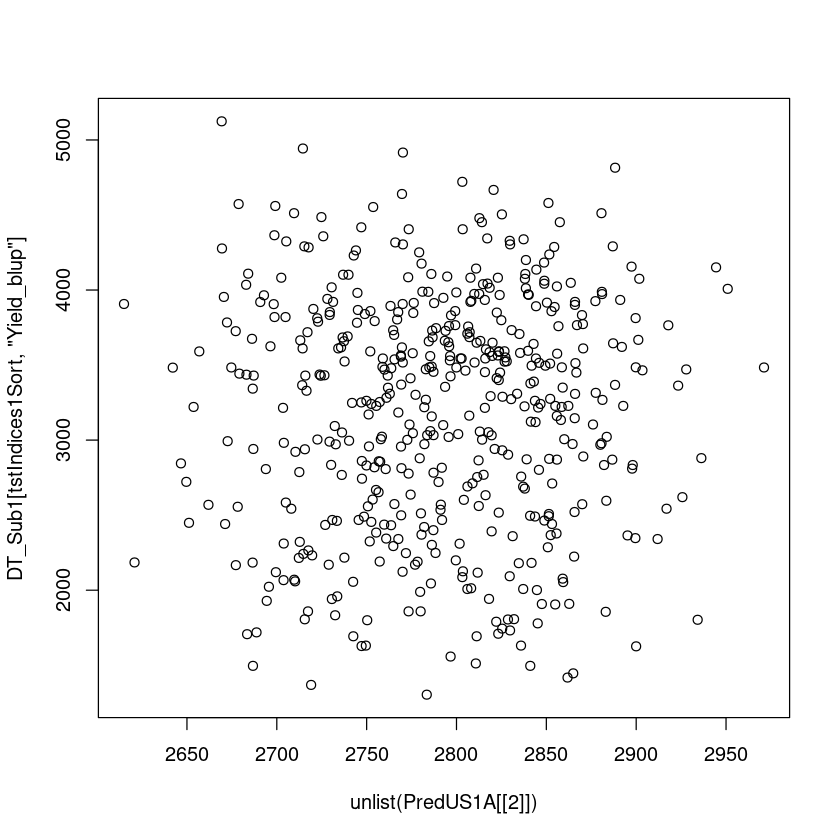

In [26]:
envNames <- levels(factor(DT_Sub1A$environ))
env1Ind <- c(1,3,6)
U_envStrain <- list()
PredUS1A <- list()
  for(i in 1:length(envNames)){
       envInd <-  grep(envNames[i],names(fitUS1A$U))
       U_envStrain[[i]] <-  as.numeric(fitUS1A$U[[env1Ind[i]]]$Yield_blup)
     for(j  in 2:length(envInd)){ 
         indJ <- envInd[j]
         b <- cbind(names(fitUS1A$U[[indJ]]$Yield_blup),fitUS1A$U[[indJ]]$Yield_blup)
         colnames(b) <- c("strain","Yield_blup")
         b_group <- as_tibble(b) %>% group_by(strain)
         YldBlup_group <- b_group %>% summarise(Yield_blup = sum(as.numeric(Yield_blup)))
         U_envStrain[[i]] <- U_envStrain[[i]] + YldBlup_group[,2] 
       } 
        PredUS1A[[i]] <- c(U_envStrain[[i]] + fitUS$Beta[i,3])
     }
    
tstIndices1Sort <- match(names(fitUS1A$U[[3]]$Yield_blup), DT_Sub1[tstIndices1,"strain"])
cor(unlist(PredUS1A[[2]]),DT_Sub1[tstIndices1Sort,"Yield_blup"])
plot(unlist(PredUS1A[[2]]),DT_Sub1[tstIndices1Sort,"Yield_blup"])

<br />

#### **2b - Untested Genotypes in Tested Environments** ####

In [28]:
### Subset Data to generate untested genotypes 
#### CV1 in Jarquin et al., 2014
set.seed(125)
tstStrain <- sample(unique(DT_Sub1[,"strain"]),0.2*length(unique(DT_Sub1[,"strain"])))
length(tstStrain)
tstIndices2 <- which(DT_Sub1[,"strain"] %in% tstStrain)
DT_Sub1B <- DT_Sub1
DT_Sub1B[tstIndices2 ,"Yield_blup"] <- NA
dim(DT_Sub1B)


[1] 98

[1] 1482   16

#### **Fit Compound Symmetry Var-Covar Structure for Tested Environments**

In [29]:
fitCSDG1B <- mmer(Yield_blup~environ-1,
                random=~vsr(strain,Gu=A_Sub1) +vsr(dsr(environ),strain,Gu=A_Sub1),
                rcov=~units,
                data=DT_Sub1B,verbose=FALSE) 

summary(fitCSDG1B)

======================================================================
              Multivariate Linear Mixed Model fit by REML              
***************************  sommer 4.1  *************************** 
======================================================================
         logLik      AIC     BIC Method Converge
Value -429.3494 864.6989 879.939     NR     TRUE
======================================================================
Variance-Covariance components:
                                      VarComp VarCompSE  Zratio Constraint
u:strain.Yield_blup-Yield_blup          985.5      9306  0.1059   Positive
IA_2012:strain.Yield_blup-Yield_blup   9333.6     16707  0.5587   Positive
IA_2013:strain.Yield_blup-Yield_blup  47043.7     27695  1.6986   Positive
IL_2012:strain.Yield_blup-Yield_blup  70698.3     33920  2.0842   Positive
units.Yield_blup-Yield_blup          349950.6     15134 23.1237   Positive
======================================================================
Fixed effects:
       Trait         Effect Estimate Std.Error t.value
1 Yield_blup environIA_2012     3133     30.03  104.32
2 Yield_blup environIA_2013     2796     30.70   91.07
3 Yield_blup environIL_2012     3610     30.99  116.49
======================================================================
Groups and observations:
               Yield_blup
u:strain              494
IA_2012:strain        494
IA_2013:strain        494
IL_2012:strain        494
======================================================================
Use the '$' sign to access results and parameters

In [30]:
m2 <- cbind(c(rep(1,nrow(DT_Sub1B)/3),rep(0,2*nrow(DT_Sub1B)/3)),c(rep(0,nrow(DT_Sub1B)/3),rep(1,nrow(DT_Sub1B)/3),rep(0,nrow(DT_Sub1B)/3)),
c(rep(0,nrow(DT_Sub1B)/3),rep(0,nrow(DT_Sub1B)/3),rep(1,nrow(DT_Sub1B)/3)))

m_beta <- m2 %*% as.numeric(fitCSDG1B$Beta[,3]) 
length(m_beta)
m_env_strain <- do.call(cbind,lapply(fitCSDG1B$U,function(x) x$Yield_blup))
dim(m_env_strain)
envStrain_blup <-c(m_env_strain[,2:4])                              
                  
strain_blup <- rep(fitCSDG1B$U$`u:strain`$Yield_blup,3)
length(strain_blup)

[1] 1482

[1] 494   4

[1] 1482

0.5401706


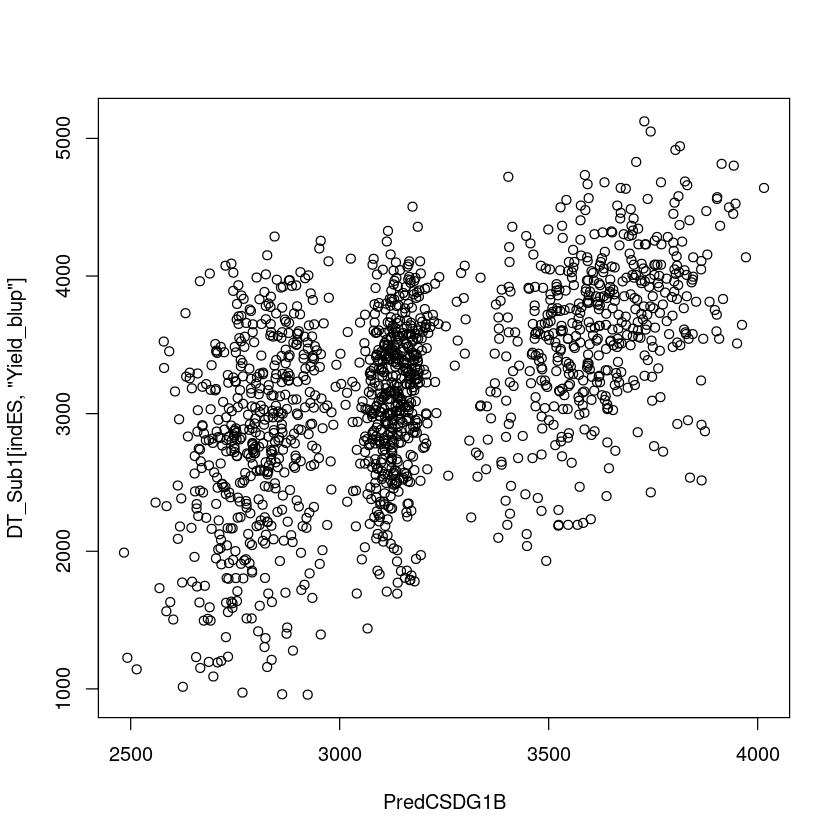

In [31]:
PredCSDG1B<- m_beta+strain_blup+envStrain_blup

indES <-  sort.int(as.numeric(DT_Sub1[,"environ"]),decreasing=FALSE,index.return=TRUE)[[2]]

cor(PredCSDG1B,DT_Sub1[indES,"Yield_blup"]) 
plot(PredCSDG1B,DT_Sub1[indES,"Yield_blup"])

**Envirotyping**

In [ ]:
### install from github using devtools
#library(devtools)
#devtools::install_github('allogamous/EnvRtype',force=TRUE)
#library(EnvRtype)


In [34]:
system("module load udunits")
system("module load gdal")
system("module load proj")
system("module load netcdf")
system("module load geos")



# install.packages("units")
# install.packages("terra",dependencies=TRUE)
# install.packages(c("BGGE",'foreach','doParallel','raster','rgdal','nasapower'))

In [ ]:
# install.packages("EnvRtype_1.1.1.tar.gz", repos = NULL, type="source") 

In [ ]:
module load udunits
module load gdal
module load proj
module load netcdf
module load geos

In [35]:
library(EnvRtype)

#system("curl -V")


Attaching package: ‘EnvRtype’


The following object is masked from ‘package:stats’:

    gaussian




In [36]:
NAM_Env <- c("Boone","Urbana","Boone")
NAM_Count <- c("USA1","USA1","USA1")
lat <- c(42.0208,40.06482,42.0208)
long <- c(-93.7741,-88.24263,-93.7741) 
startDay <- c("2012-03-01","2012-03-01","2013-03-01")
endDay <- c("2012-12-01","2012-12-01","2013-12-01")

env.data.NAM <- get_weather(env.id = NAM_Env,lat = lat,
                         lon =long,start.day = startDay,
                         end.day = endDay, country = NAM_Count,parallel=TRUE,workers=2)

env.data.NAM.environ <- paste(env.data.NAM$env,env.data.NAM$YEAR,sep="-")
env.data.NAM$environ <- as.factor(env.data.NAM.environ)

env.data.NAM2 <- env.data.NAM
env.data.NAM2$env <- env.data.NAM2$environ

------------------------------------------------ 
ATTENTION: This function requires internet access 
------------------------------------------------  
Connecting to the NASA POWER API Client, Sparks et al 2018 
https://docs.ropensci.org/nasapower 
------------------------------------------------  


ERROR: Error in checkForRemoteErrors(val): 2 nodes produced errors; first error: An unknown option was passed in to libcurl


In [ ]:
var = c("PRECTOT","T2MDEW")

card = list(PRECTOT = c(0,5,10,25,40,100),
            T2MDEW = NULL)
ET.NAM <-  env_typing(env.data = env.data.NAM2, env.id = "env",
                  var.id = var, cardinals = card)

var2 = c("PRECTOT","T2M","ALLSKY_SFC_SW_DWN","RH2M")
EC.NAM = W_matrix(env.data = env.data.NAM2,env.id="env", var.id = var2)




In [ ]:
###
DT_Sub1A <- droplevels(DT_Sub1A)
KE = list(W = env_kernel(env.data = EC.NAM)[[2]])


colnames(KE$W) <- levels(factor(DT_Sub1A$environ))
rownames(KE$W) <- levels(factor(DT_Sub1A$environ))
KG = list(G=A_Sub1);
y = "Yield_blup" # name of the vector of phenotypes
gid = "strain" # name of the vector of genotypes
env = "environ"

## Creating kernel models with get_kernel
MM = get_kernel(K_G = KG, y=y, gid = gid, env = env, data = DT_Sub1A, model = "MM")
MDs = get_kernel(K_G = KG, y=y, gid = gid, env = env, data = DT_Sub1A, model = "MDs")

EMM = get_kernel(K_G = KG, K_E = KE, y= y, gid = gid, env = env, data = DT_Sub1A,model = "EMM")
EMDs = get_kernel(K_G = KG, K_E = KE, y=y, gid = gid, env = env, data = DT_Sub1A,model = "EMDs")

RNMM = get_kernel(K_G = KG, K_E = KE, y=y, gid = gid, env = env, data = DT_Sub1A, model = "RNMM")
RNMDs = get_kernel(K_G = KG, K_E = KE, y=y, gid = gid, env = env, data = DT_Sub1A, model = "RNMDs")


In [ ]:
###BOX 13. Basic usage of kernel_model function
fixed=model.matrix(~0+environ,DT_Sub1A)
fit_MM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1A, random=MM, fixed=fixed)
fit_MDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1A, random=MDs, fixed=fixed)
fit_EMDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1A, random=EMDs, fixed=fixed)
fit_EMM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1A, random=EMM, fixed=fixed)


fit_RNMDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1A, random=RNMDs, fixed=fixed)
fit_RNMM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1A, random=RNMM, fixed=fixed)




In [ ]:
cor(fit_MM$yHat[tstIndices1],DT_Sub1[tstIndices1,y])
cor(fit_MDs$yHat[tstIndices1],DT_Sub1[tstIndices1,y])
cor(fit_EMM$yHat[tstIndices1],DT_Sub1[tstIndices1,y])
cor(fit_EMDs$yHat[tstIndices1],DT_Sub1[tstIndices1,y])
cor(fit_RNMM$yHat[tstIndices1],DT_Sub1[tstIndices1,y])
cor(fit_RNMDs$yHat[tstIndices1],DT_Sub1[tstIndices1,y])

In [ ]:
phenoIndices <- setdiff(c(1:nrow(DT_Sub1A)),tstIndices1)
cor(fit_EMM$yHat[phenoIndices],DT_Sub1A[phenoIndices,y])
cor(fit_RNMDs$yHat[phenoIndices],DT_Sub1A[phenoIndices,y])


In [ ]:
###
 KE = list(W = env_kernel(env.data = EC.NAM)[[2]])
 colnames(KE$W) <- levels(DT_Sub1A$environ)
 rownames(KE$W) <- levels(DT_Sub1A$environ)
 KG = list(G=A_Sub1);

 corMM_List_CV1 <- list()
 corMDs_List_CV1 <-list()
 corEMM_List_CV1 <- list()
 corEMDs_List_CV1 <- list()
 corRNMM_List_CV1 <- list()
 corRNMDs_List_CV1 <- list()

for(nrep in 1:5){
    set.seed(125+nrep)
    tstStrain <- sample(unique(DT_Sub1[,"strain"]),0.2*length(unique(DT_Sub1[,"strain"])))
    length(tstStrain)
    tstIndices2 <- which(DT_Sub1[,"strain"] %in% tstStrain)
    DT_Sub1B <- DT_Sub1
    DT_Sub1B[tstIndices2 ,"Yield_blup"] <- NA
    dim(DT_Sub1B)
    DT_Sub1B <- droplevels(DT_Sub1B)
    y = "Yield_blup" # name of the vector of phenotypes
    gid = "strain" # name of the vector of genotypes
    env = "environ"

    ## Creating kernel models with get_kernel
    MM = get_kernel(K_G = KG, y=y, gid = gid, env = env, data = DT_Sub1B, model = "MM")
    MDs = get_kernel(K_G = KG, y=y, gid = gid, env = env, data = DT_Sub1B, model = "MDs")

    EMM = get_kernel(K_G = KG, K_E = KE, y= y, gid = gid, env = env, data = DT_Sub1B,model = "EMM")
    EMDs = get_kernel(K_G = KG, K_E = KE, y=y, gid = gid, env = env, data = DT_Sub1B,model = "EMDs")

    RNMM = get_kernel(K_G = KG, K_E = KE, y=y, gid = gid, env = env, data = DT_Sub1B, model = "RNMM")
    RNMDs = get_kernel(K_G = KG, K_E = KE, y=y, gid = gid, env = env, data = DT_Sub1B, model = "RNMDs")


    fixed=model.matrix(~0+environ,DT_Sub1B)

    fit_MM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=MM, fixed=fixed)
    fit_MDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=MDs, fixed=fixed)

    fit_EMM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=EMM, fixed=fixed)
    fit_EMDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=EMDs, fixed=fixed)

    fit_RNMM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=RNMM, fixed=fixed)
    fit_RNMDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=RNMDs, fixed=fixed)


    corMM_List_CV1[[nrep]] <-cor(fit_MM$yHat[tstIndices2],DT_Sub1[tstIndices2,"Yield_blup"])
    corMDs_List_CV1[[nrep]] <-cor(fit_MDs$yHat[tstIndices2],DT_Sub1[tstIndices2,"Yield_blup"])

    corEMM_List_CV1[[nrep]] <- cor(fit_EMM$yHat[tstIndices2],DT_Sub1[tstIndices2,"Yield_blup"])
    corEMDs_List_CV1[[nrep]] <-cor(fit_EMDs$yHat[tstIndices2],DT_Sub1[tstIndices2,"Yield_blup"])

    corRNMM_List_CV1[[nrep]] <-cor(fit_RNMM$yHat[tstIndices2],DT_Sub1[tstIndices2,"Yield_blup"])
    corRNMDs_List_CV1[[nrep]] <-cor(fit_RNMDs$yHat[tstIndices2],DT_Sub1[tstIndices2,"Yield_blup"])
}
    
 

In [ ]:
fixed=model.matrix(~0+environ,DT_Sub1A)

fit_MM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=MM, fixed=fixed)
fit_MDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=MDs, fixed=fixed)

fit_EMM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=EMM, fixed=fixed)
fit_EMDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=EMDs, fixed=fixed)

fit_RNMM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=RNMM, fixed=fixed)
fit_RNMDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1B, random=RNMDs, fixed=fixed)


In [ ]:
cor(fit_MM$yHat[tstIndices2],DT_Sub1B[tstIndices2,"Yield_blup"])
cor(fit_MDs$yHat[tstIndices2],DT_Sub1B[tstIndices2,"Yield_blup"])

cor(fit_EMM$yHat[tstIndices2],DT_Sub1B[tstIndices2,"Yield_blup"])
cor(fit_EMDs$yHat[tstIndices2],DT_Sub1B[tstIndices2,"Yield_blup"])

cor(fit_RNMM$yHat[tstIndices2],DT_Sub1B[tstIndices2,"Yield_blup"])
cor(fit_RNMDs$yHat[tstIndices2],DT_Sub1B[tstIndices2,"Yield_blup"])


#### **2c -Tested Genotypes in Tested Environments** ####


In [ ]:
### Subset Data to generate some untested genotypes in tested environments
#### CV2 in Jarquin et al., 2014
 
 KE = list(W = env_kernel(env.data = EC.NAM)[[2]])
 colnames(KE$W) <- levels(DT_Sub1A$environ)
 rownames(KE$W) <- levels(DT_Sub1A$environ)
 KG = list(G=A_Sub1);

 corMM_List_CV2 <- list()
 corMDs_List_CV2 <-list()
 corEMM_List_CV2 <- list()
 corEMDs_List_CV2 <- list()
 corRNMM_List_CV2 <- list()
 corRNMDs_List_CV2 <- list()


for(nrep in 1:5){
    set.seed(125+nrep)
    tstIndices3 <- sample(c(1:length(DT_Sub1[,"strain"])),0.2*length(DT_Sub1[,"strain"]))
    DT_Sub1C <- DT_Sub1
    DT_Sub1C[tstIndices3 ,"Yield_blup"] <- NA
    dim(DT_Sub1C)

    y = "Yield_blup" # name of the vector of phenotypes
    gid = "strain" # name of the vector of genotypes
    env = "environ"

  ## Creating kernel models with get_kernel
   
    MM = get_kernel(K_G = KG, y=y, gid = gid, env = env, data = DT_Sub1C, model = "MM")
    MDs = get_kernel(K_G = KG, y=y, gid = gid, env = env, data = DT_Sub1C, model = "MDs")

    EMM = get_kernel(K_G = KG, K_E = KE, y= y, gid = gid, env = env, data = DT_Sub1C,model = "EMM")
    EMDs = get_kernel(K_G = KG, K_E = KE, y=y, gid = gid, env = env, data = DT_Sub1C,model = "EMDs")

    RNMM = get_kernel(K_G = KG, K_E = KE, y=y, gid = gid, env = env, data = DT_Sub1C, model = "RNMM")
    RNMDs = get_kernel(K_G = KG, K_E = KE, y=y, gid = gid, env = env, data = DT_Sub1C, model = "RNMDs")


    fixed=model.matrix(~0+environ,DT_Sub1C)

    fit_MM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1C, random=MM, fixed=fixed)
    fit_MDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1C, random=MDs, fixed=fixed)

    fit_EMM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1C, random=EMM, fixed=fixed)
    fit_EMDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1C, random=EMDs, fixed=fixed)

    fit_RNMM=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1C, random=RNMM, fixed=fixed)
    fit_RNMDs=kernel_model(y=y, env=env, gid=gid, data=DT_Sub1C, random=RNMDs, fixed=fixed)


    corMM_List_CV2[[nrep]] <-cor(fit_MM$yHat[tstIndices3],DT_Sub1[tstIndices3,"Yield_blup"])
    corMDs_List_CV2[[nrep]] <-cor(fit_MDs$yHat[tstIndices3],DT_Sub1[tstIndices3,"Yield_blup"])

    corEMM_List_CV2[[nrep]] <- cor(fit_EMM$yHat[tstIndices3],DT_Sub1[tstIndices3,"Yield_blup"])
    corEMDs_List_CV2[[nrep]] <-cor(fit_EMDs$yHat[tstIndices3],DT_Sub1[tstIndices3,"Yield_blup"])

    corRNMM_List_CV2[[nrep]] <-cor(fit_RNMM$yHat[tstIndices3],DT_Sub1[tstIndices3,"Yield_blup"])
    corRNMDs_List_CV2[[nrep]] <-cor(fit_RNMDs$yHat[tstIndices3],DT_Sub1[tstIndices3,"Yield_blup"])

     
 }



#### **Discuss other ways to model these scenarios and refine these models**